<a href="https://colab.research.google.com/github/taidopurason/evolutionary-harmonization/blob/main/evolutionary_harmonization_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies


!git clone https://github.com/taidopurason/evolutionary-harmonization
!mv evolutionary-harmonization/* . 

!sudo apt-get update
!sudo apt-get install lilypond

!pip install mingus

!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Cloning into 'evolutionary-harmonization'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 81 (delta 41), reused 58 (delta 24), pack-reused 0
Unpacking objects: 100% (81/81), done.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.0 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4

In [2]:
#@title Implement midi playing

from IPython.display import Audio

def play_midi(filename):
    !fluidsynth -ni font.sf2 {filename} -F {filename}.wav -r 44100 > /dev/null
    return Audio(filename + ".wav")

In [3]:
from fractions import Fraction
from typing import Iterable, Tuple
import logging

from mingus.containers import Composition
from mingus.extra import lilypond
from mingus.extra.lilypond import from_Track
from mingus.midi.midi_file_out import write_Composition

from evolution import HarmonyGene, genetic_algorithm, TournamentSelection, EarlyStopping
from mingus_utils import create_composition, test_melody, test_chords, create_melody
from utils import note_match_fitness, note_mismatch_penalty, chord_progression_fitness

from IPython.display import Image

The melody is defined as a sequence of bars, which themself are sequences of tuples of note and the duration:

In [4]:
test_melody

((('C-5', Fraction(3, 16)), ('C-5', Fraction(1, 16))),
 (('D-5', Fraction(1, 4)), ('C-5', Fraction(1, 4)), ('F-5', Fraction(1, 4))),
 (('E-5', Fraction(1, 2)), ('C-5', Fraction(3, 16)), ('C-5', Fraction(1, 16))),
 (('D-5', Fraction(1, 4)), ('C-5', Fraction(1, 4)), ('G-5', Fraction(1, 4))),
 (('F-5', Fraction(1, 2)), (None, Fraction(1, 4))))

Executing: lilypond -fpng -o "melody" "melody.ly"


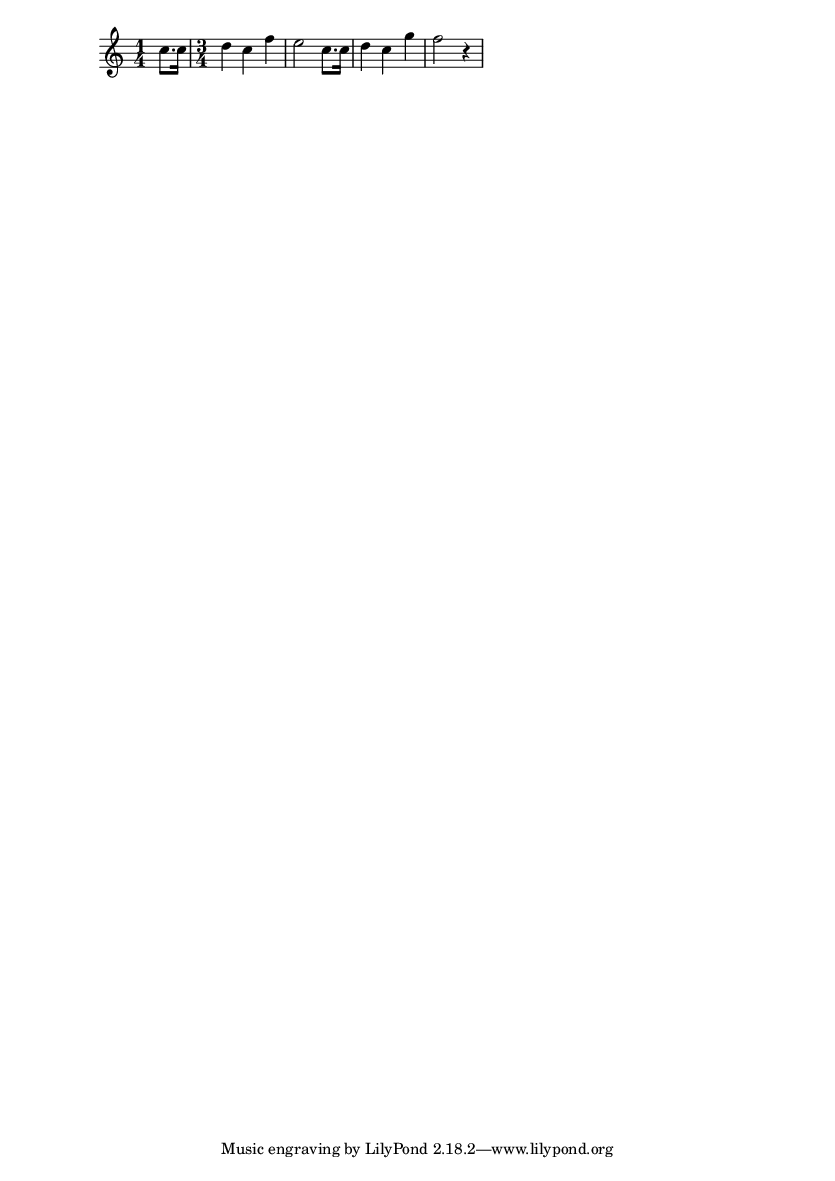

In [5]:
melody = lilypond.from_Track(create_melody(test_melody))
lilypond.to_png(melody, "melody.png")
Image(filename='melody.png')

In [6]:
#@title Generate chords

logging.basicConfig(
        format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        level=logging.INFO,
    )

def fitness(
    gene: HarmonyGene, melody: 
    Iterable[Tuple[Tuple[str, Fraction]]], 
    key: str, 
    match_weight=1.0, 
    bar_mismatch_weight=0.7,
    song_mismatch_weight=0.3,
    progression_fitness_weight=1.0
) -> float:

    melody_notes = set(note[0] for bar in melody for note in bar)

    fitness = 0
    for chord, bar in zip(gene, melody):
        bar_notes = set(note[0] for note in bar)
        fitness += match_weight * note_match_fitness(chord, bar_notes)
        fitness -= bar_mismatch_weight * note_mismatch_penalty(chord, bar_notes)
        fitness -= song_mismatch_weight * note_mismatch_penalty(chord, melody_notes)

    fitness += progression_fitness_weight * chord_progression_fitness(gene.gene, key)

    return fitness



alphabet = "F Gm Am Bb C Dm Edim" #@param ["F Gm Am Bb C Dm Edim"] {allow-input: true}

# only diatonic chords
#alphabet = ["F", "Gm", "Am", "Bb", "C", "Dm", "Edim"] 
alphabet = list(set(alphabet.split(" ")))

key = "F"
n_population = len(test_melody)

#@markdown Fitness function weights
match_weight = 1.0 #@param {type:"slider", min:0, max:1, step:0.01}
bar_mismatch_weight = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
song_mismatch_weight = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
progression_fitness_weight = 1.0 #@param {type:"slider", min:0, max:1, step:0.01}

f = lambda x: fitness(
    x, 
    test_melody, 
    key,
    match_weight=match_weight, 
    bar_mismatch_weight=bar_mismatch_weight,
    song_mismatch_weight=song_mismatch_weight,
    progression_fitness_weight=progression_fitness_weight
)

print("Alphabet", alphabet)
initial_pop = HarmonyGene.initialize_population(n_population * 10, n_population, alphabet)
generated_chords, score = genetic_algorithm(
    f,
    initial_pop,
    TournamentSelection(5),
    p_crossover=0.8,
    p_mutation=0.3,
    epochs=500,
    callbacks=[EarlyStopping(30)]
)
print("Best score:", score)
print("Generated chords", generated_chords)

gen_comp = create_composition(test_melody, generated_chords)
write_Composition("generated.midi", gen_comp)

play_midi("generated.midi")

Alphabet ['Gm', 'C', 'Dm', 'F', 'Am', 'Bb', 'Edim']


2022-01-20 21:11:57 | INFO | evolution | The fitness has not improved for 30 epochs. Stopping training at epoch 29


Best score: 1.0833333333333335
Generated chords HarmonyGene(['C', 'Bb', 'C', 'C', 'F'])


In [7]:
#@title Display chords

def lilypond_from_composition(composition: Composition, chord_idx = 1) -> Composition:
    result = '\\header { title = "%s" composer = "%s" opus = "%s" } ' % (
        composition.title,
        composition.author,
        composition.subtitle,
    )
    result += "<< "

    for i, track in enumerate(composition.tracks):
        if i == chord_idx:
            result += f"\\new ChordNames {from_Track(track)} "
        else:
            result += from_Track(track)

    result += ">>"
    return result

Executing: lilypond -fpng -o "gen_comp" "gen_comp.ly"


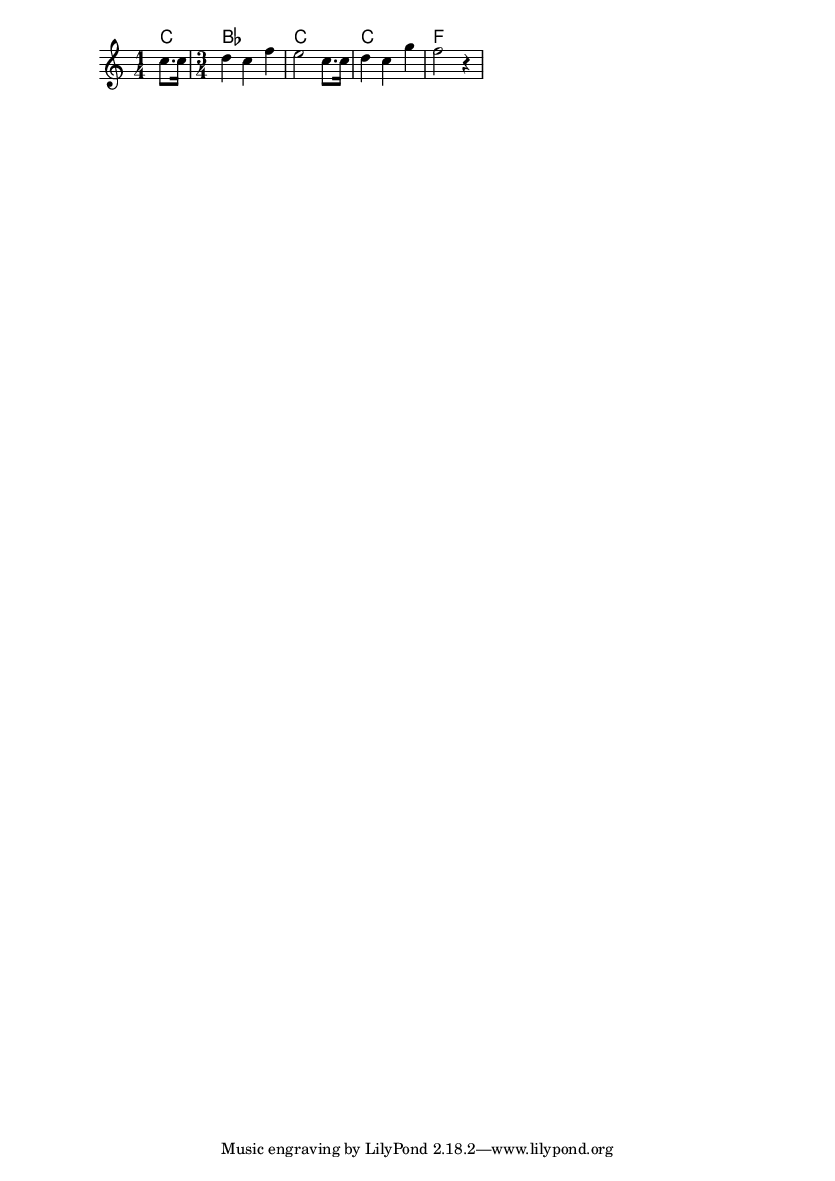

In [8]:
gen_comp.title = ""
comp = lilypond_from_composition(gen_comp)
lilypond.to_png(comp, "gen_comp.png")
Image(filename='gen_comp.png')